In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgi
from governance import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cProfile

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
num_decisions = 6
num_people = 10000

select_decision_type = "snowball"
select_group_type = "star"
make_decision_type = "average"
update_opinions_type = "star"

# opinions = create_opinions(num_people, num_decisions)
opinions = create_polarized_opinions(
    num_people, num_decisions, [1, -1, -1, -1, -1, 1], 0.2, 0.2
)
votes = 2 * (np.mean(opinions, axis=0) > 0) - 1

# decision_matrix = create_decision_matrix(num_decisions)
decision_matrix = np.array(
    [
        [0, -1, -1, -1, -1, 1],
        [-1, 0, 0, 0, 0, 0],
        [-1, 0, 0, 0, 0, 0],
        [-1, 0, 0, 0, 0, 0],
        [-1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
    ]
)
print(decision_matrix)

[[ 0 -1 -1 -1 -1  1]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [-1  0  0  0  0  0]
 [ 1  0  0  0  0  0]]


In [4]:
group_size = 51
overlap = 6

# opinions = create_opinions(num_people, num_decisions)
opinions = create_polarized_opinions(
    num_people, num_decisions, [1, -1, -1, -1, -1, 1], 0.33, 0.6
)
cProfile.run(
    "decision_process(opinions, decision_matrix, group_size, overlap, select_decision_type=select_decision_type, select_group_type=select_group_type, make_decision_type=make_decision_type, update_opinions_type=update_opinions_type)"
)

         4422 function calls (4418 primitive calls) in 0.004 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.004    0.004 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 _collections_abc.py:315(__subclasshook__)
        6    0.000    0.000    0.000    0.000 _collections_abc.py:635(__and__)
       11    0.000    0.000    0.000    0.000 _collections_abc.py:638(<genexpr>)
       18    0.000    0.000    0.000    0.000 abc.py:117(__instancecheck__)
      3/1    0.000    0.000    0.000    0.000 abc.py:121(__subclasscheck__)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:2177(sum)
       11    0.000    0.000    0.000    0.000 fromnumeric.py:3214(_size_dispatcher)
       11    0.000    0.000    0.000    0.000 fromnumeric.py:3218(size)
        6    0.000    0.000    0.000    0.000 fromn

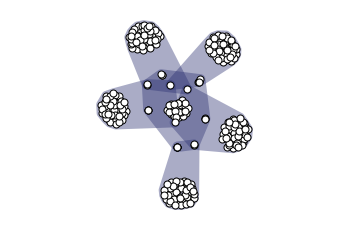

In [5]:
group_size = 51
overlap = 6

# opinions = create_opinions(num_people, num_decisions)
opinions = create_polarized_opinions(
    num_people, num_decisions, [1, -1, -1, -1, -1, 1], 0.33, 0.6
)
decisions, final_opinions, decision_groups = decision_process(
    opinions,
    decision_matrix,
    group_size,
    overlap,
    select_decision_type=select_decision_type,
    select_group_type=select_group_type,
    make_decision_type=make_decision_type,
    update_opinions_type=update_opinions_type,
)
# d = decisions_to_array(decisions)
H = decision_groups
coherence = 0
for d1, d2 in np.ndindex(decision_matrix.shape):
    coherence += decision_matrix[d1, d2] * decisions[d1] * decisions[d2]

fig = matplotlib.pyplot.figure()
xgi.draw(H, xgi.pairwise_spring_layout(H), node_size=7, hull=True, radius=0.05)

fig.savefig("Figures/example_hypergraph.pdf", dpi=1000)
fig.savefig("Figures/example_hypergraph.png", dpi=1000)

In [120]:
method = "random"

In [121]:
num_samples = 100
group_sizes = np.arange(1, 51, 2, dtype=int)
overlap_sizes = np.arange(0, 21, 1, dtype=int)
satisfaction_group_size = np.zeros((len(group_sizes),num_samples))
satisfiability_group_size = np.zeros((len(group_sizes),num_samples))
overlap = 0
H_group_sizes = dict()

for i in range(len(group_sizes)):
    g = group_sizes[i]
    print(i / len(group_sizes))
    for j in range(num_samples):
        if method=='random':
            opinions = create_random_opinions(num_people, num_decisions)
        elif method=="polarized":
            opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.33,0.6)
        elif method=="zealots":
            opinions = create_mixed_opinions(num_people, num_decisions,[0.6,-0.4,-0.4,-0.4,-0.4,0.6],0.0,0.7)
        elif method=="incoherent":
            opinions = create_incoherent_opinions(num_people, num_decisions,[0.6,0.4,0.4,0.4,0.4,-0.6])
        # binary_votes = 2*(np.mean(opinions, axis=0)>0)-1
        votes = np.mean(opinions, axis=0)
        decisions, final_opinions, decision_groups = decision_process(
            opinions,
            decision_matrix,
            g,
            overlap,
            select_decision_type=select_decision_type,
            select_group_type=select_group_type,
            make_decision_type=make_decision_type,
            update_opinions_type=update_opinions_type,
        )
        # H_group_sizes[(g, overlap, j)] = decision_groups
        d = decisions_to_array(decisions)
        # satisfaction_group_size[i] += np.mean(opinions.dot(d))/num_samples
        satisfaction_group_size[i,j] += (votes.dot(d)/np.sum(np.abs(votes)))# / num_samples
        for d1, d2 in np.ndindex(decision_matrix.shape):
            satisfiability_group_size[i,j] += (
                decision_matrix[d1, d2] * decisions[d1] * decisions[d2] #/ num_samples
            )

0.0
0.04
0.08
0.12
0.16
0.2
0.24
0.28
0.32
0.36
0.4
0.44
0.48
0.52
0.56
0.6
0.64
0.68
0.72
0.76
0.8
0.84
0.88
0.92
0.96


In [122]:
num_samples = 100
group_sizes = np.arange(1, 51, 2, dtype=int)
overlap_sizes = np.arange(0, 21, 1, dtype=int)
satisfaction_overlap_size = np.zeros((len(overlap_sizes),num_samples))
satisfiability_overlap_size = np.zeros((len(overlap_sizes),num_samples))
group_size = 50  # max(overlap_sizes) + 1

H_overlap_sizes = dict()

for i in range(len(overlap_sizes)):
    o = overlap_sizes[i]
    print(i / len(overlap_sizes))
    for j in range(num_samples):
        if method=='random':
            opinions = create_random_opinions(num_people, num_decisions)
        elif method=="polarized":
            opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.33,0.6)
        elif method=="zealots":
            opinions = create_mixed_opinions(num_people, num_decisions,[0.6,-0.4,-0.4,-0.4,-0.4,0.6],0.0,0.7)
        elif method=="incoherent":
            opinions = create_incoherent_opinions(num_people, num_decisions,[0.6,0.4,0.4,0.4,0.4,-0.6])
        # binary_votes = 2*(np.mean(opinions, axis=0)>0)-1
        votes = np.mean(opinions, axis=0)
        decisions, final_opinions, decision_groups = decision_process(
            opinions,
            decision_matrix,
            group_size,
            o,
            select_decision_type=select_decision_type,
            select_group_type=select_group_type,
            make_decision_type=make_decision_type,
            update_opinions_type=update_opinions_type,
        )
        H_overlap_sizes[(group_size, o, j)] = decision_groups
        d = decisions_to_array(decisions)
        # satisfaction_overlap_size[i] += np.mean(opinions.dot(d))/num_samples
        satisfaction_overlap_size[i,j] += (votes.dot(d)/np.sum(np.abs(votes)))# / num_samples
        for d1, d2 in np.ndindex(decision_matrix.shape):
            satisfiability_overlap_size[i,j] += (
                decision_matrix[d1, d2] * decisions[d1] * decisions[d2] #/ num_samples
            )

0.0
0.047619047619047616
0.09523809523809523
0.14285714285714285
0.19047619047619047
0.23809523809523808
0.2857142857142857
0.3333333333333333
0.38095238095238093
0.42857142857142855
0.47619047619047616
0.5238095238095238
0.5714285714285714
0.6190476190476191
0.6666666666666666
0.7142857142857143
0.7619047619047619
0.8095238095238095
0.8571428571428571
0.9047619047619048
0.9523809523809523


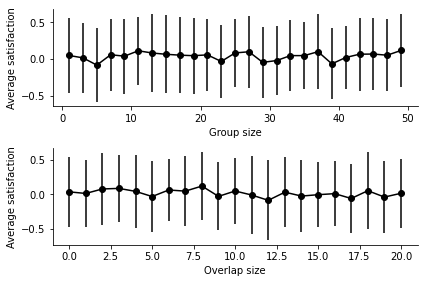

In [123]:
plt.figure()
plt.subplot(211)
plt.errorbar(group_sizes, satisfaction_group_size.mean(axis=1), yerr=satisfaction_group_size.std(axis=1), color="black", marker="o")
plt.ylabel("Average satisfaction")
plt.xlabel("Group size")
sns.despine()

plt.subplot(212)
plt.errorbar(overlap_sizes, satisfaction_overlap_size.mean(axis=1), yerr=satisfaction_overlap_size.std(axis=1), color="black", marker="o")
plt.ylabel("Average satisfaction")
plt.xlabel("Overlap size")
plt.tight_layout()
sns.despine()


plt.show()

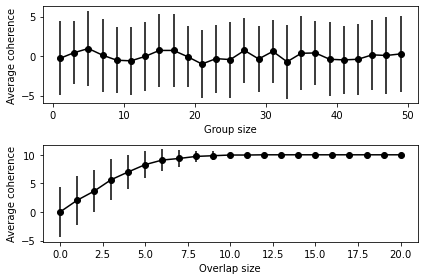

In [124]:
plt.figure()
plt.subplot(211)
plt.errorbar(group_sizes, satisfiability_group_size.mean(axis=1), yerr=satisfiability_group_size.std(axis=1), color="black", marker="o")
plt.ylabel("Average coherence")
plt.xlabel("Group size")
plt.subplot(212)
plt.errorbar(overlap_sizes, satisfiability_overlap_size.mean(axis=1), yerr=satisfiability_overlap_size.std(axis=1), color="black", marker="o")
plt.ylabel("Average coherence")
plt.xlabel("Overlap size")
plt.tight_layout()
plt.show()

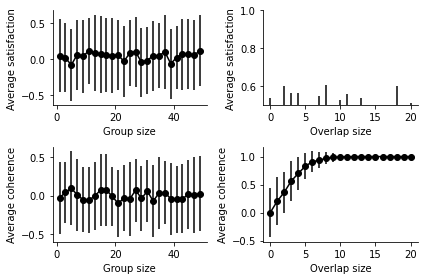

In [125]:
plt.figure()
plt.subplot(221)
plt.errorbar(group_sizes, satisfaction_group_size.mean(axis=1), yerr=satisfaction_group_size.std(axis=1), color="black", marker="o")
plt.ylabel("Average satisfaction")
plt.xlabel("Group size")
sns.despine()

plt.subplot(222)
plt.errorbar(overlap_sizes, satisfaction_overlap_size.mean(axis=1), yerr=satisfaction_overlap_size.std(axis=1), color="black", marker="o")
plt.ylabel("Average satisfaction")
plt.xlabel("Overlap size")
plt.ylim(0.5, 1)
sns.despine()

plt.subplot(223)
plt.errorbar(group_sizes, satisfiability_group_size.mean(axis=1)/10, yerr=satisfiability_group_size.std(axis=1)/10, color="black", marker="o")
plt.ylabel("Average coherence")
plt.xlabel("Group size")
sns.despine()

plt.subplot(224)
plt.errorbar(overlap_sizes, satisfiability_overlap_size.mean(axis=1)/10, yerr=satisfiability_overlap_size.std(axis=1)/10, color="black", marker="o")
plt.ylabel("Average coherence")
plt.xlabel("Overlap size")
sns.despine()

plt.tight_layout()
plt.show()

In [126]:
num_samples = 100
group_sizes = np.arange(1, 51, 2, dtype=int)
overlap_sizes = np.arange(0, 21, 1, dtype=int)
satisfaction_heatmap = np.zeros((len(group_sizes),len(overlap_sizes)))
satisfiability_heatmap = np.zeros((len(group_sizes),len(overlap_sizes)))
overlap = 0
H_group_sizes = dict()

for i in range(len(group_sizes)):
    g = group_sizes[i]
    for j in range(len(overlap_sizes)):
        o = overlap_sizes[j]
        if o>g:
            satisfaction_heatmap[i,j] = np.nan
            satisfiability_heatmap[i,j] = np.nan
        else:
            print(i / len(group_sizes), o / len(overlap_sizes))
            for n in range(num_samples):
                if method=='random':
                    opinions = create_random_opinions(num_people, num_decisions)
                elif method=="polarized":
                    opinions = create_polarized_opinions(num_people, num_decisions,[1,-1,-1,-1,-1,1],0.33,0.6)
                elif method=="zealots":
                    opinions = create_mixed_opinions(num_people, num_decisions,[0.6,-0.4,-0.4,-0.4,-0.4,0.6],0.0,0.7)
                elif method=="incoherent":
                    opinions = create_incoherent_opinions(num_people, num_decisions,[0.6,0.4,0.4,0.4,0.4,-0.6])
                votes = np.mean(opinions, axis=0)
                decisions, final_opinions, decision_groups = decision_process(
                    opinions,
                    decision_matrix,
                    g,
                    o,
                    select_decision_type=select_decision_type,
                    select_group_type=select_group_type,
                    make_decision_type=make_decision_type,
                    update_opinions_type=update_opinions_type,
                )
                # H_group_sizes[(g, overlap, j)] = decision_groups
                d = decisions_to_array(decisions)
                # satisfaction_group_size[i] += np.mean(opinions.dot(d))/num_samples
                satisfaction_heatmap[i,j] += (votes.dot(d)/np.sum(np.abs(votes))) / num_samples
                for d1, d2 in np.ndindex(decision_matrix.shape):
                    satisfiability_heatmap[i,j] += (
                        decision_matrix[d1, d2] * decisions[d1] * decisions[d2] / num_samples
                    )

                    
if method=='random':
    np.savetxt("Simulations/random_satisfaction_heatmap.csv", satisfiability_heatmap, delimiter=",")
    np.savetxt("Simulations/random_satisfiability_heatmap.csv", satisfiability_heatmap, delimiter=",")
elif method=="polarized":
    np.savetxt("Simulations/polarized_satisfaction_heatmap.csv", satisfiability_heatmap, delimiter=",")
    np.savetxt("Simulations/polarized_satisfiability_heatmap.csv", satisfiability_heatmap, delimiter=",")
elif method=="zealots":
    np.savetxt("Simulations/zealots_satisfaction_heatmap.csv", satisfiability_heatmap, delimiter=",")
    np.savetxt("Simulations/zealots_satisfiability_heatmap.csv", satisfiability_heatmap, delimiter=",")
elif method=="incoherent":
    np.savetxt("Simulations/incoherent_satisfaction_heatmap.csv", satisfiability_heatmap, delimiter=",")
    np.savetxt("Simulations/incoherent_satisfiability_heatmap.csv", satisfiability_heatmap, delimiter=",")

0.0 0.0
0.0 0.047619047619047616
0.04 0.0
0.04 0.047619047619047616
0.04 0.09523809523809523
0.04 0.14285714285714285
0.08 0.0
0.08 0.047619047619047616
0.08 0.09523809523809523
0.08 0.14285714285714285
0.08 0.19047619047619047
0.08 0.23809523809523808
0.12 0.0
0.12 0.047619047619047616
0.12 0.09523809523809523
0.12 0.14285714285714285
0.12 0.19047619047619047
0.12 0.23809523809523808
0.12 0.2857142857142857
0.12 0.3333333333333333
0.16 0.0
0.16 0.047619047619047616
0.16 0.09523809523809523
0.16 0.14285714285714285
0.16 0.19047619047619047
0.16 0.23809523809523808
0.16 0.2857142857142857
0.16 0.3333333333333333
0.16 0.38095238095238093
0.16 0.42857142857142855
0.2 0.0
0.2 0.047619047619047616
0.2 0.09523809523809523
0.2 0.14285714285714285
0.2 0.19047619047619047
0.2 0.23809523809523808
0.2 0.2857142857142857
0.2 0.3333333333333333
0.2 0.38095238095238093
0.2 0.42857142857142855
0.2 0.47619047619047616
0.2 0.5238095238095238
0.24 0.0
0.24 0.047619047619047616
0.24 0.09523809523809523
0

0.84 0.47619047619047616
0.84 0.5238095238095238
0.84 0.5714285714285714
0.84 0.6190476190476191
0.84 0.6666666666666666
0.84 0.7142857142857143
0.84 0.7619047619047619
0.84 0.8095238095238095
0.84 0.8571428571428571
0.84 0.9047619047619048
0.84 0.9523809523809523
0.88 0.0
0.88 0.047619047619047616
0.88 0.09523809523809523
0.88 0.14285714285714285
0.88 0.19047619047619047
0.88 0.23809523809523808
0.88 0.2857142857142857
0.88 0.3333333333333333
0.88 0.38095238095238093
0.88 0.42857142857142855
0.88 0.47619047619047616
0.88 0.5238095238095238
0.88 0.5714285714285714
0.88 0.6190476190476191
0.88 0.6666666666666666
0.88 0.7142857142857143
0.88 0.7619047619047619
0.88 0.8095238095238095
0.88 0.8571428571428571
0.88 0.9047619047619048
0.88 0.9523809523809523
0.92 0.0
0.92 0.047619047619047616
0.92 0.09523809523809523
0.92 0.14285714285714285
0.92 0.19047619047619047
0.92 0.23809523809523808
0.92 0.2857142857142857
0.92 0.3333333333333333
0.92 0.38095238095238093
0.92 0.42857142857142855
0.92

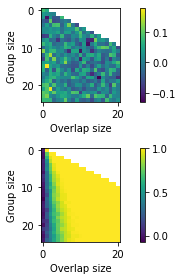

In [127]:
plt.figure()
plt.subplot(211)
hm1 = plt.imshow(satisfaction_heatmap)
plt.colorbar(hm1)
plt.ylabel("Group size")
plt.xlabel("Overlap size")
plt.subplot(212)
hm2 = plt.imshow(satisfiability_heatmap/10)
plt.colorbar(hm2)
plt.ylabel("Group size")
plt.xlabel("Overlap size")
plt.tight_layout()
plt.show()

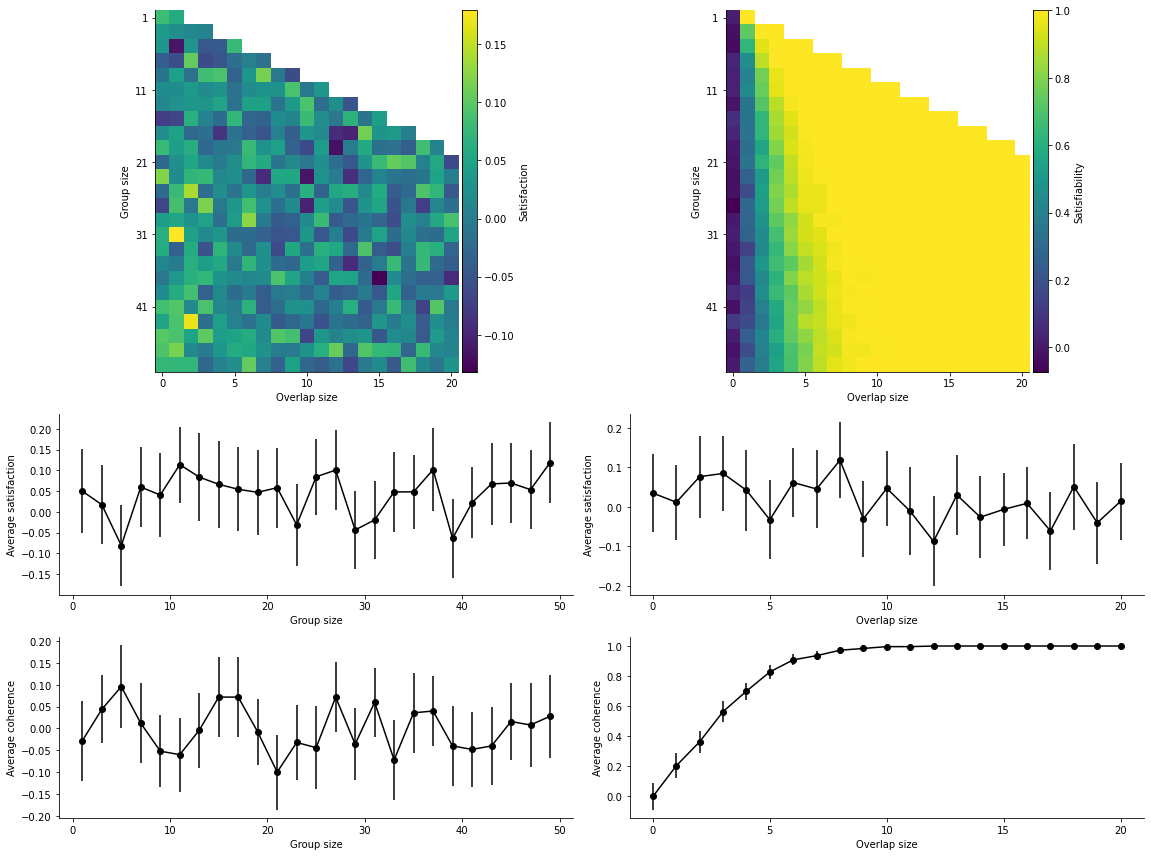

In [128]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3,2,figsize=(16,12), gridspec_kw={'height_ratios': [2, 1, 1]})

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
hm1 = ax1.imshow(satisfaction_heatmap)
cbar1 = plt.colorbar(hm1, cax=cax)
cbar1.set_label('Satisfaction')
ax1.set_ylabel("Group size")
ax1.set_xlabel("Overlap size")
ax1.set_yticks([0, 5, 10, 15, 20])
ax1.set_yticklabels([1, 11, 21, 31, 41])
ax1.set_xticks([0, 5, 10, 15, 20])


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
hm2 = ax2.imshow(satisfiability_heatmap/10)
cbar2 = plt.colorbar(hm2, cax=cax)
cbar2.set_label('Satisfiability')
ax2.set_ylabel("Group size")
ax2.set_xlabel("Overlap size")
ax2.set_yticks([0, 5, 10, 15, 20])
ax2.set_yticklabels([1, 11, 21, 31, 41])
ax2.set_xticks([0, 5, 10, 15, 20])

ax3.errorbar(group_sizes, satisfaction_group_size.mean(axis=1), yerr=1.9723*(satisfaction_group_size.std(axis=1))/np.sqrt(num_samples), color="black", marker="o")
ax3.set_ylabel("Average satisfaction")
ax3.set_xlabel("Group size")
ax3.set_xticks([0, 10, 20, 30, 40, 50])
sns.despine()

ax4.errorbar(overlap_sizes, satisfaction_overlap_size.mean(axis=1), yerr=1.9723*(satisfaction_overlap_size.std(axis=1))/np.sqrt(num_samples), color="black", marker="o")
ax4.set_ylabel("Average satisfaction")
ax4.set_xlabel("Overlap size")
ax4.set_xticks([0, 5, 10, 15, 20])
sns.despine()

ax5.errorbar(group_sizes, satisfiability_group_size.mean(axis=1)/10, yerr=1.9723*(satisfiability_group_size.std(axis=1)/10)/np.sqrt(num_samples), color="black", marker="o")
ax5.set_ylabel("Average coherence")
ax5.set_xlabel("Group size")
ax5.set_xticks([0, 10, 20, 30, 40, 50])
sns.despine()

ax6.errorbar(overlap_sizes, satisfiability_overlap_size.mean(axis=1)/10, yerr=1.9723*(satisfiability_overlap_size.std(axis=1)/10)/np.sqrt(num_samples), color="black", marker="o")
ax6.set_ylabel("Average coherence")
ax6.set_xlabel("Overlap size")
ax6.set_xticks([0, 5, 10, 15, 20])
sns.despine()

plt.tight_layout()


if method=='random':
    plt.savefig("Figures/complete_random.pdf")
    plt.savefig("Figures/complete_random.png", dpi=1000)
elif method=="polarized":
    plt.savefig("Figures/complete_polarized.pdf")
    plt.savefig("Figures/complete_polarized.png", dpi=1000)
elif method=="zealots":
    plt.savefig("Figures/complete_zealots.pdf")
    plt.savefig("Figures/complete_zealots.png", dpi=1000)
elif method=="incoherent":
    plt.savefig("Figures/complete_incoherent.pdf")
    plt.savefig("Figures/complete_incoherent.png", dpi=1000)
plt.show()

(<AxesSubplot:>,
 (<matplotlib.collections.PathCollection at 0x7f8781501840>,
  <matplotlib.collections.PatchCollection at 0x7f8783d43130>))

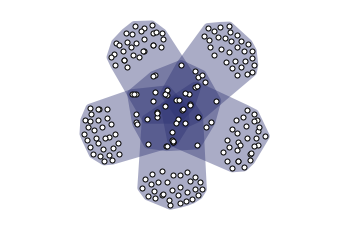

In [119]:
key = (50, 20, 1)
xgi.draw(
    H_overlap_sizes[key],
    xgi.pairwise_spring_layout(H_overlap_sizes[key]),
    node_size=5,
    hull=True,
    radius=0.05,
)

In [15]:
key = (20, 1, 1)
xgi.draw(
    H_group_sizes[key],
    xgi.pairwise_spring_layout(H_group_sizes[key]),
    node_size=5,
    hull=True,
)

KeyError: (20, 1, 1)

## 